In [9]:
!pip install -q kaggle timm h5py torchmetrics tqdm seaborn matplotlib scikit-learn torchinfo

import os
import json
import h5py
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import timm

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

from torchmetrics.classification import (
    MulticlassAccuracy,
    MulticlassPrecision,
    MulticlassRecall,
    MulticlassF1Score,
    MulticlassAUROC,
    MulticlassMatthewsCorrCoef
)

from torchinfo import summary

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)


Using device: cuda


In [10]:
KAGGLE_USERNAME = "YOUR_USERNAME"
KAGGLE_KEY = "YOUR_KEY"

os.makedirs("/root/.config/kaggle", exist_ok=True)
with open("/root/.config/kaggle/kaggle.json", "w") as f:
    json.dump({"username": KAGGLE_USERNAME, "key": KAGGLE_KEY}, f)
os.chmod("/root/.config/kaggle/kaggle.json", 0o600)

from kaggle.api.kaggle_api_extended import KaggleApi

DATA_DIR = "brain_tumor_dataset"
DATASET = "ashkhagan/figshare-brain-tumor-dataset"

if not os.path.exists(DATA_DIR):
    api = KaggleApi()
    api.authenticate()
    api.dataset_download_files(DATASET, path=DATA_DIR, unzip=True)


In [11]:
mat_files = []
for root, _, files in os.walk(DATA_DIR):
    for f in files:
        if f.endswith(".mat") and "cvind" not in f.lower():
            mat_files.append(os.path.join(root, f))

paths, labels = [], []

for f in mat_files:
    with h5py.File(f, "r") as mat:
        if "label" in mat:
            label = int(mat["label"][()][0][0])
        else:
            label = int(mat["cjdata"]["label"][()][0][0])
    paths.append(f)
    labels.append(label - 1)

df = pd.DataFrame({"image_path": paths, "label": labels})
num_classes = df["label"].nunique()

train_df, test_df = train_test_split(df, stratify=df.label, test_size=0.2, random_state=42)
train_df, val_df  = train_test_split(train_df, stratify=train_df.label, test_size=0.2, random_state=42)


In [12]:
class BrainTumorDataset(Dataset):
    def __init__(self, df, transform):
        self.df = df.reset_index(drop=True)
        self.transform = transform

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        path = self.df.loc[idx, "image_path"]
        label = self.df.loc[idx, "label"]

        with h5py.File(path, "r") as mat:
            if "image" in mat:
                img = mat["image"][()]
            else:
                img = mat["cjdata"]["image"][()]

        img = np.array(img).T
        img = np.stack([img]*3, axis=-1).astype(np.uint8)
        img = self.transform(img)

        return img, label


In [13]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])

train_loader = DataLoader(BrainTumorDataset(train_df, transform), batch_size=8, shuffle=True)
val_loader   = DataLoader(BrainTumorDataset(val_df, transform), batch_size=8)
test_loader  = DataLoader(BrainTumorDataset(test_df, transform), batch_size=8)


In [6]:
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize((0.485,0.456,0.406),
                         (0.229,0.224,0.225))
])

train_loader = DataLoader(BrainTumorDataset(train_df, transform), batch_size=8, shuffle=True)
val_loader   = DataLoader(BrainTumorDataset(val_df, transform), batch_size=8)
test_loader  = DataLoader(BrainTumorDataset(test_df, transform), batch_size=8)


In [14]:
model = timm.create_model(
    "convnextv2_base.fcmae_ft_in22k_in1k",
    pretrained=True
)

model.head.fc = nn.Linear(model.head.fc.in_features, num_classes)
model = model.to(device)

summary(model, input_size=(1,3,224,224))


Layer (type:depth-idx)                                       Output Shape              Param #
ConvNeXt                                                     [1, 3]                    --
├─Sequential: 1-1                                            [1, 128, 56, 56]          --
│    └─Conv2d: 2-1                                           [1, 128, 56, 56]          6,272
│    └─LayerNorm2d: 2-2                                      [1, 128, 56, 56]          256
├─Sequential: 1-2                                            [1, 1024, 7, 7]           --
│    └─ConvNeXtStage: 2-3                                    [1, 128, 56, 56]          --
│    │    └─Identity: 3-1                                    [1, 128, 56, 56]          --
│    │    └─Sequential: 3-2                                  [1, 128, 56, 56]          418,176
│    └─ConvNeXtStage: 2-4                                    [1, 256, 28, 28]          --
│    │    └─Sequential: 3-3                                  [1, 256, 28, 28]         

In [15]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-4)

EPOCHS = 30
patience = 5

scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer,
    T_max=EPOCHS
)


In [16]:
def get_metrics():
    return {
        "acc": MulticlassAccuracy(num_classes=num_classes).to(device),
        "precision": MulticlassPrecision(num_classes=num_classes, average="macro").to(device),
        "recall": MulticlassRecall(num_classes=num_classes, average="macro").to(device),
        "f1": MulticlassF1Score(num_classes=num_classes, average="macro").to(device),
        "auc": MulticlassAUROC(num_classes=num_classes).to(device),
        "mcc": MulticlassMatthewsCorrCoef(num_classes=num_classes).to(device)
    }

def multiclass_specificity_sensitivity(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    spec, sens = [], []

    for i in range(num_classes):
        tp = cm[i,i]
        fn = cm[i,:].sum() - tp
        fp = cm[:,i].sum() - tp
        tn = cm.sum() - (tp+fp+fn)

        spec.append(tn/(tn+fp+1e-8))
        sens.append(tp/(tp+fn+1e-8))

    return float(np.mean(spec)), float(np.mean(sens))


In [17]:
history = {
    "loss": [], "val_loss": [],
    "accuracy": [], "val_accuracy": [],
    "precision": [], "val_precision": [],
    "recall": [], "val_recall": [],
    "f1": [], "val_f1": [],
    "specificity": [], "val_specificity": [],
    "sensitivity": [], "val_sensitivity": [],
    "mcc": [], "val_mcc": [],
    "auc": [], "val_auc": []
}

best_val_loss = float("inf")
counter = 0

for epoch in range(EPOCHS):

    # ================= TRAIN =================
    model.train()
    train_loss = 0
    train_preds, train_targets = [], []
    train_metrics = get_metrics()

    pbar = tqdm(train_loader, desc=f"Training Model - Epoch [{epoch+1}/{EPOCHS}]")

    for x,y in pbar:
        x,y = x.to(device), y.to(device)

        optimizer.zero_grad()
        out = model(x)
        loss = criterion(out,y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()
        preds = out.argmax(1)

        train_preds.append(preds.cpu())
        train_targets.append(y.cpu())

        for m in train_metrics.values():
            m.update(out,y)

    train_loss /= len(train_loader)

    train_preds = torch.cat(train_preds).numpy()
    train_targets = torch.cat(train_targets).numpy()

    train_spec, train_sens = multiclass_specificity_sensitivity(train_targets, train_preds)
    train_out = {k:v.compute().item() for k,v in train_metrics.items()}

    print(f"Metrics - loss: {train_loss:.4f}, accuracy: {train_out['acc']:.4f}, "
          f"precision: {train_out['precision']:.4f}, recall: {train_out['recall']:.4f}, "
          f"f1_score: {train_out['f1']:.4f}, specificity: {train_spec:.4f}, "
          f"sensitivity: {train_sens:.4f}, mcc: {train_out['mcc']:.4f}, "
          f"auc: {train_out['auc']:.4f}")

    # Save history
    history["loss"].append(train_loss)
    history["accuracy"].append(train_out["acc"])
    history["precision"].append(train_out["precision"])
    history["recall"].append(train_out["recall"])
    history["f1"].append(train_out["f1"])
    history["specificity"].append(train_spec)
    history["sensitivity"].append(train_sens)
    history["mcc"].append(train_out["mcc"])
    history["auc"].append(train_out["auc"])

    # ================= VALID =================
    model.eval()
    val_loss = 0
    val_preds, val_targets = [], []
    val_metrics = get_metrics()

    with torch.no_grad():
        for x,y in tqdm(val_loader, desc="Validating Model"):
            x,y = x.to(device), y.to(device)

            out = model(x)
            loss = criterion(out,y)
            val_loss += loss.item()

            preds = out.argmax(1)
            val_preds.append(preds.cpu())
            val_targets.append(y.cpu())

            for m in val_metrics.values():
                m.update(out,y)

    val_loss /= len(val_loader)

    val_preds = torch.cat(val_preds).numpy()
    val_targets = torch.cat(val_targets).numpy()

    val_spec, val_sens = multiclass_specificity_sensitivity(val_targets, val_preds)
    val_out = {k:v.compute().item() for k,v in val_metrics.items()}

    print(f"Metrics - loss: {val_loss:.4f}, accuracy: {val_out['acc']:.4f}, "
          f"precision: {val_out['precision']:.4f}, recall: {val_out['recall']:.4f}, "
          f"f1_score: {val_out['f1']:.4f}, specificity: {val_spec:.4f}, "
          f"sensitivity: {val_sens:.4f}, mcc: {val_out['mcc']:.4f}, "
          f"auc: {val_out['auc']:.4f}")

    print(f"Current LR: {optimizer.param_groups[0]['lr']:.6e}\n")

    scheduler.step()

    history["val_loss"].append(val_loss)
    history["val_accuracy"].append(val_out["acc"])
    history["val_precision"].append(val_out["precision"])
    history["val_recall"].append(val_out["recall"])
    history["val_f1"].append(val_out["f1"])
    history["val_specificity"].append(val_spec)
    history["val_sensitivity"].append(val_sens)
    history["val_mcc"].append(val_out["mcc"])
    history["val_auc"].append(val_out["auc"])

    # Early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
        torch.save(model.state_dict(), "best_model.pth")
    else:
        counter += 1
        if counter >= patience:
            print("Early stopping triggered.")
            break


Training Model - Epoch [1/30]: 100%|██████████| 245/245 [02:28<00:00,  1.65it/s]


Metrics - loss: 1.1193, accuracy: 0.3226, precision: 0.3118, recall: 0.3226, f1_score: 0.2886, specificity: 0.6610, sensitivity: 0.3226, mcc: -0.0212, auc: 0.4841


Validating Model: 100%|██████████| 62/62 [00:15<00:00,  3.88it/s]


Metrics - loss: 1.0720, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.6910
Current LR: 5.000000e-04



Training Model - Epoch [2/30]: 100%|██████████| 245/245 [02:29<00:00,  1.64it/s]


Metrics - loss: 1.0802, accuracy: 0.3294, precision: 0.3355, recall: 0.3294, f1_score: 0.2567, specificity: 0.6635, sensitivity: 0.3294, mcc: -0.0144, auc: 0.4993


Validating Model: 100%|██████████| 62/62 [00:13<00:00,  4.56it/s]


Metrics - loss: 1.0567, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.4821
Current LR: 4.986305e-04



Training Model - Epoch [3/30]: 100%|██████████| 245/245 [02:25<00:00,  1.69it/s]


Metrics - loss: 1.0705, accuracy: 0.3326, precision: 0.2567, recall: 0.3326, f1_score: 0.2485, specificity: 0.6660, sensitivity: 0.3326, mcc: -0.0035, auc: 0.4960


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s]


Metrics - loss: 1.0776, accuracy: 0.3333, precision: 0.1012, recall: 0.3333, f1_score: 0.1552, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.7446
Current LR: 4.945369e-04



Training Model - Epoch [4/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 1.0633, accuracy: 0.3350, precision: 0.3636, recall: 0.3350, f1_score: 0.2171, specificity: 0.6675, sensitivity: 0.3350, mcc: 0.0233, auc: 0.4994


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.85it/s]


Metrics - loss: 1.0595, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.7369
Current LR: 4.877641e-04



Training Model - Epoch [5/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 1.0639, accuracy: 0.3333, precision: 0.1551, recall: 0.3333, f1_score: 0.2117, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.4994


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.87it/s]


Metrics - loss: 1.0628, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.7332
Current LR: 4.783864e-04



Training Model - Epoch [6/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 0.9820, accuracy: 0.4360, precision: 0.3861, recall: 0.4360, f1_score: 0.3847, specificity: 0.7257, sensitivity: 0.4360, mcc: 0.2466, auc: 0.6292


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.84it/s]


Metrics - loss: 1.0596, accuracy: 0.3774, precision: 0.4660, recall: 0.3774, f1_score: 0.2985, specificity: 0.6914, sensitivity: 0.3774, mcc: 0.1942, auc: 0.7329
Current LR: 4.665064e-04



Training Model - Epoch [7/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 1.0693, accuracy: 0.3412, precision: 0.2822, recall: 0.3412, f1_score: 0.2520, specificity: 0.6713, sensitivity: 0.3412, mcc: 0.0313, auc: 0.5108


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.83it/s]


Metrics - loss: 1.0566, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.7360
Current LR: 4.522542e-04



Training Model - Epoch [8/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 1.0603, accuracy: 0.3333, precision: 0.1551, recall: 0.3333, f1_score: 0.2117, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.4928


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.85it/s]


Metrics - loss: 1.0632, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.7412
Current LR: 4.357862e-04



Training Model - Epoch [9/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 1.0633, accuracy: 0.3307, precision: 0.2455, recall: 0.3307, f1_score: 0.2313, specificity: 0.6650, sensitivity: 0.3307, mcc: -0.0126, auc: 0.4956


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.85it/s]


Metrics - loss: 1.0635, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.7194
Current LR: 4.172827e-04



Training Model - Epoch [10/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 1.0610, accuracy: 0.3333, precision: 0.1551, recall: 0.3333, f1_score: 0.2117, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.5055


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.85it/s]


Metrics - loss: 1.0767, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.2837
Current LR: 3.969463e-04



Training Model - Epoch [11/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 1.0632, accuracy: 0.3333, precision: 0.1551, recall: 0.3333, f1_score: 0.2117, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.4829


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s]


Metrics - loss: 1.0568, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.7357
Current LR: 3.750000e-04



Training Model - Epoch [12/30]: 100%|██████████| 245/245 [02:24<00:00,  1.70it/s]


Metrics - loss: 1.0594, accuracy: 0.3333, precision: 0.1551, recall: 0.3333, f1_score: 0.2117, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.4899


Validating Model: 100%|██████████| 62/62 [00:12<00:00,  4.81it/s]

Metrics - loss: 1.0604, accuracy: 0.3333, precision: 0.1555, recall: 0.3333, f1_score: 0.2120, specificity: 0.6667, sensitivity: 0.3333, mcc: 0.0000, auc: 0.7384
Current LR: 3.516842e-04

Early stopping triggered.


In [18]:
# Load best model
model.load_state_dict(torch.load("best_model.pth"))
model.eval()


ConvNeXt(
  (stem): Sequential(
    (0): Conv2d(3, 128, kernel_size=(4, 4), stride=(4, 4))
    (1): LayerNorm2d((128,), eps=1e-06, elementwise_affine=True)
  )
  (stages): Sequential(
    (0): ConvNeXtStage(
      (downsample): Identity()
      (blocks): Sequential(
        (0): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), groups=128)
          (norm): LayerNorm((128,), eps=1e-06, elementwise_affine=True)
          (mlp): GlobalResponseNormMlp(
            (fc1): Linear(in_features=128, out_features=512, bias=True)
            (act): GELU()
            (drop1): Dropout(p=0.0, inplace=False)
            (grn): GlobalResponseNorm()
            (fc2): Linear(in_features=512, out_features=128, bias=True)
            (drop2): Dropout(p=0.0, inplace=False)
          )
          (shortcut): Identity()
          (drop_path): Identity()
        )
        (1): ConvNeXtBlock(
          (conv_dw): Conv2d(128, 128, kernel_size=(7, 7), strid

In [19]:
test_metrics = get_metrics()
test_loss = 0
all_preds, all_targets = [], []

with torch.no_grad():
    for x, y in tqdm(test_loader, desc="Testing"):
        x, y = x.to(device), y.to(device)

        out = model(x)
        loss = criterion(out, y)
        test_loss += loss.item()

        preds = out.argmax(1)

        all_preds.append(preds.cpu())
        all_targets.append(y.cpu())

        for m in test_metrics.values():
            m.update(out, y)

test_loss /= len(test_loader)

print("\n===== TEST RESULTS =====")
print(f"Test Loss: {test_loss:.4f}")

for k, v in test_metrics.items():
    print(f"{k.upper()}: {v.compute().item():.4f}")


Testing: 100%|██████████| 77/77 [00:18<00:00,  4.20it/s]


===== TEST RESULTS =====
Test Loss: 1.0566
ACC: 0.3333
PRECISION: 0.1550
RECALL: 0.3333
F1: 0.2116
AUC: 0.7196
MCC: 0.0000


In [20]:
all_preds = torch.cat(all_preds).numpy()
all_targets = torch.cat(all_targets).numpy()

print("\n===== CLASSIFICATION REPORT =====\n")
print(classification_report(all_targets, all_preds, digits=4))



===== CLASSIFICATION REPORT =====

              precision    recall  f1-score   support

           0     0.0000    0.0000    0.0000       142
           1     0.4649    1.0000    0.6347       285
           2     0.0000    0.0000    0.0000       186

    accuracy                         0.4649       613
   macro avg     0.1550    0.3333    0.2116       613
weighted avg     0.2162    0.4649    0.2951       613



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


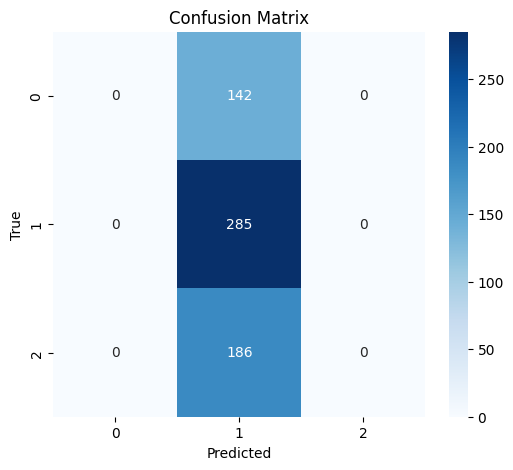

In [21]:
cm = confusion_matrix(all_targets, all_preds)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()


In [22]:
def plot_metric(train, val, title, ylabel):
    epochs = range(1, len(train) + 1)
    plt.figure(figsize=(6,4))
    plt.plot(epochs, train, label="Training")
    plt.plot(epochs, val, label="Validation")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel(ylabel)
    plt.legend()
    plt.grid(True, linestyle="--", alpha=0.5)
    plt.show()


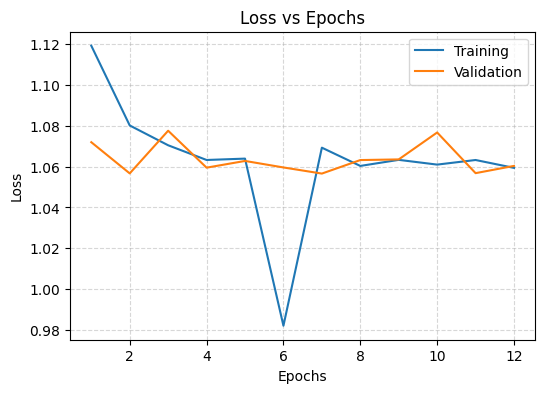

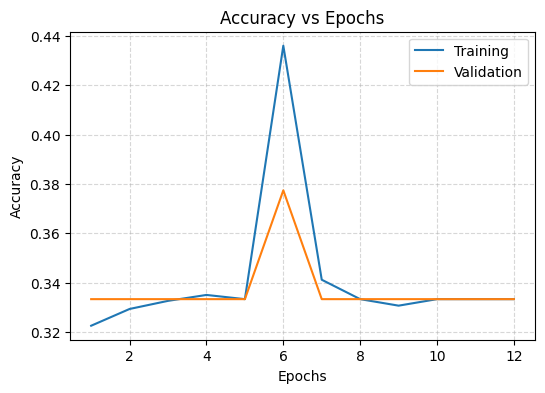

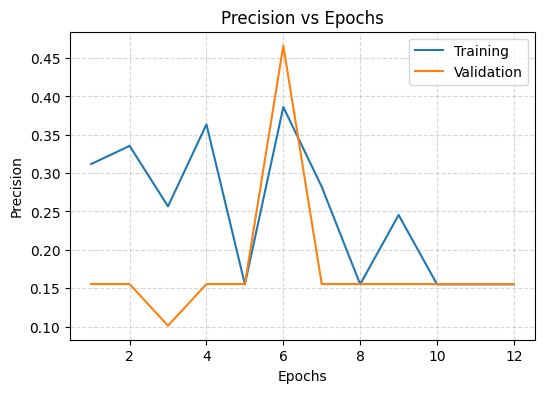

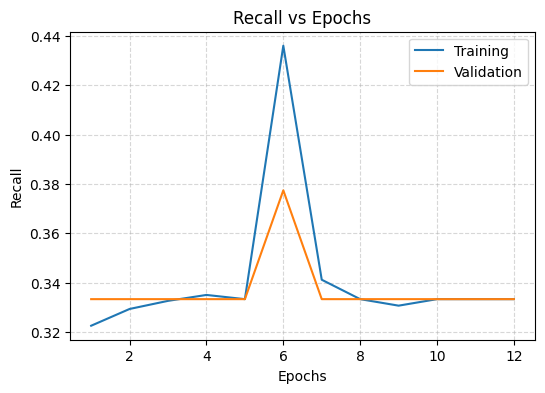

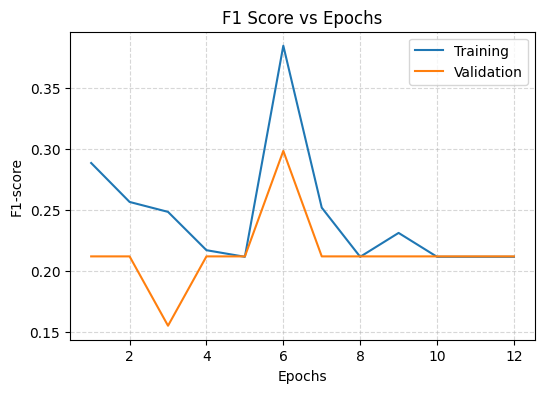

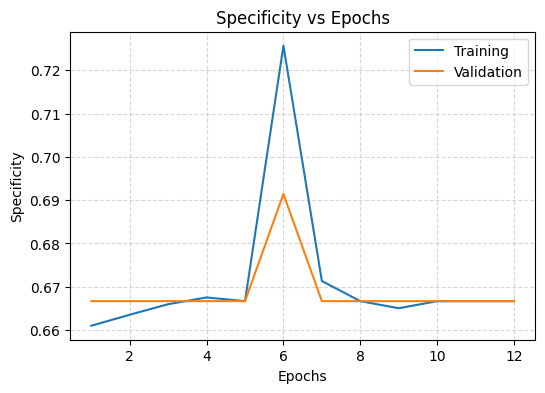

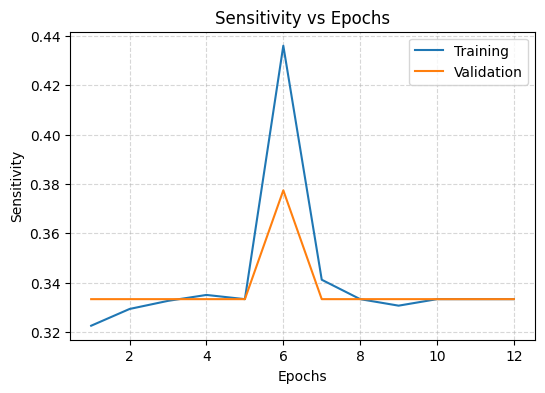

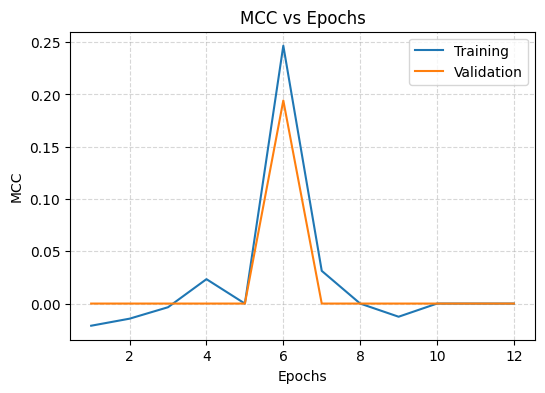

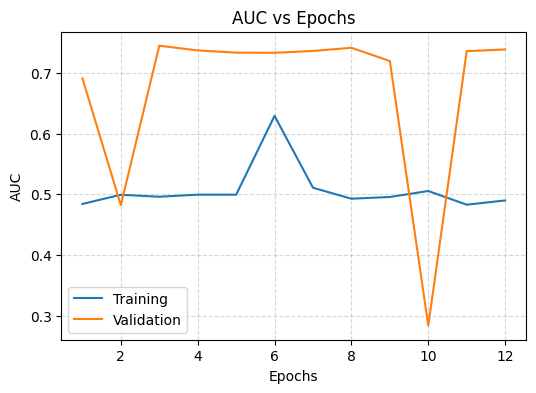

In [23]:
plot_metric(history["loss"], history["val_loss"], "Loss vs Epochs", "Loss")
plot_metric(history["accuracy"], history["val_accuracy"], "Accuracy vs Epochs", "Accuracy")
plot_metric(history["precision"], history["val_precision"], "Precision vs Epochs", "Precision")
plot_metric(history["recall"], history["val_recall"], "Recall vs Epochs", "Recall")
plot_metric(history["f1"], history["val_f1"], "F1 Score vs Epochs", "F1-score")
plot_metric(history["specificity"], history["val_specificity"], "Specificity vs Epochs", "Specificity")
plot_metric(history["sensitivity"], history["val_sensitivity"], "Sensitivity vs Epochs", "Sensitivity")
plot_metric(history["mcc"], history["val_mcc"], "MCC vs Epochs", "MCC")
plot_metric(history["auc"], history["val_auc"], "AUC vs Epochs", "AUC")
